## This code is to get the distribution of preferred direction within individual animal

In [1]:
import os
import numpy as np
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

import utils

%load_ext autoreload
%autoreload 2

In [2]:
def plot_head_direction_tuning(ax, angle_data, angle4spike, config, pos_tb=0.01):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """


    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(angle_data, bins=config['hd_bins'], range=(-np.pi, np.pi))
    hd2, _ = np.histogram(angle4spike, bins=config['hd_bins'], range=(-np.pi, np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time
    # #where hd3 is nan, set it to 0
    # hd3 = np.nan_to_num(hd3)
    
    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.nanmax(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(-np.pi, np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    
    #remove yticks
    ax.set_yticks([])
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    prefer_hd = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([prefer_hd, prefer_hd], [0, 1], color='red', linestyle='--', linewidth=1)
    
    return ax, prefer_hd

processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3709-200601/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3713-200909a/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3703-191215/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3728-210309b/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3730-210323b/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3705-200306/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3708-200317b/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3706-200313/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3723-201115/Data
processing /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/A3717-201021/Data
processing /home/zilong/Desktop/HDPhasePrecession/Duszki

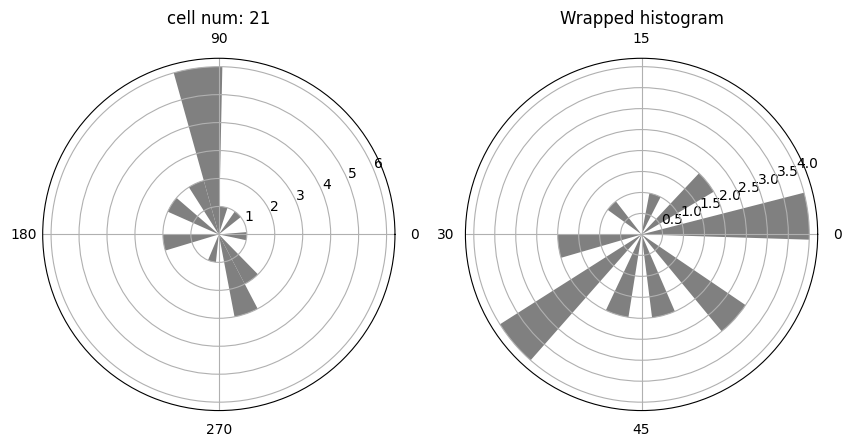

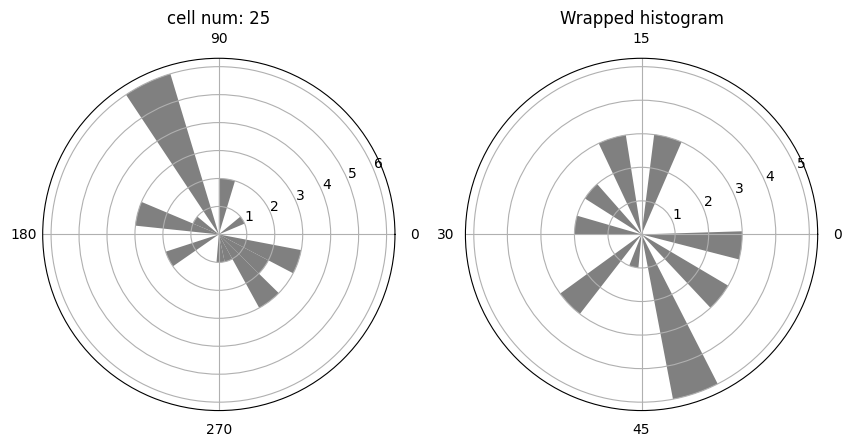

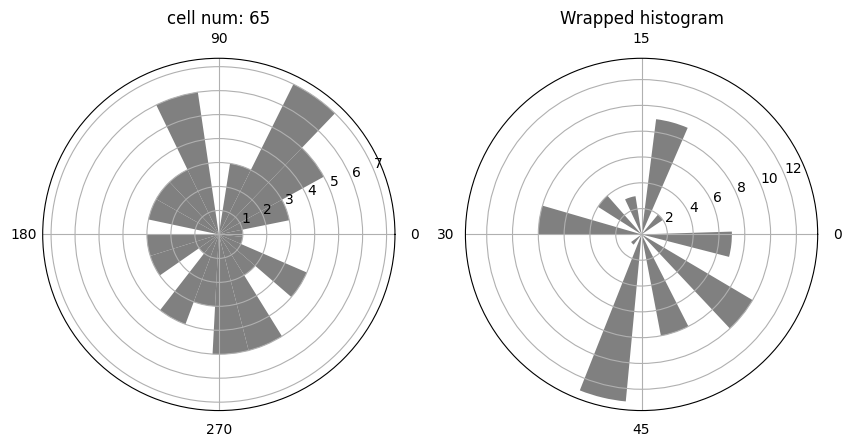

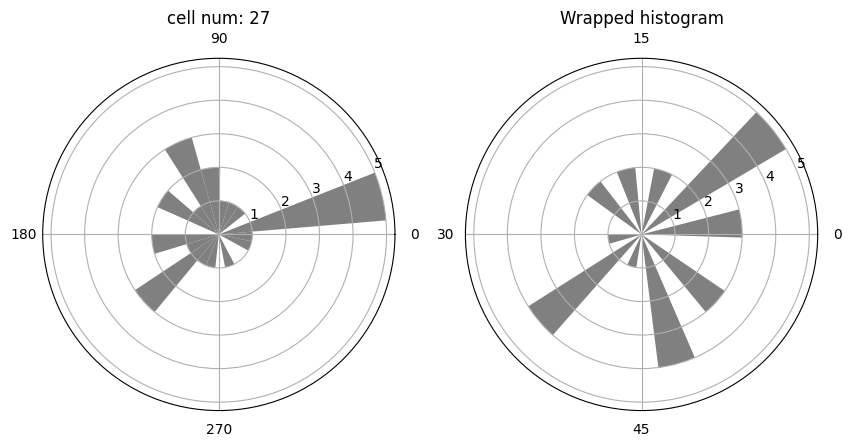

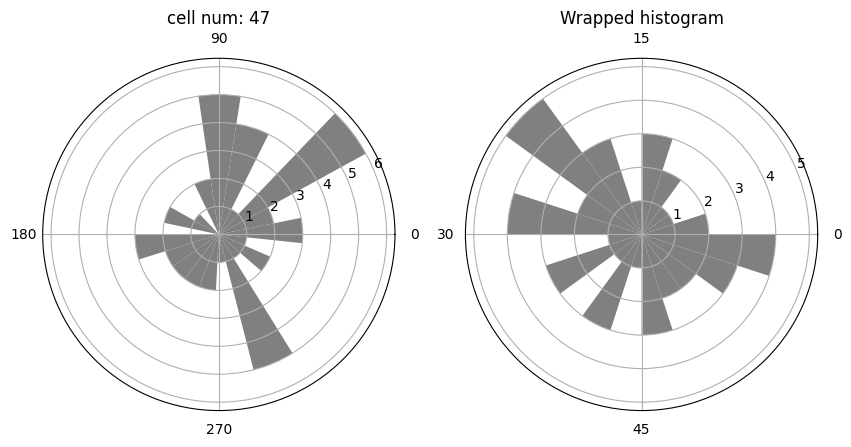

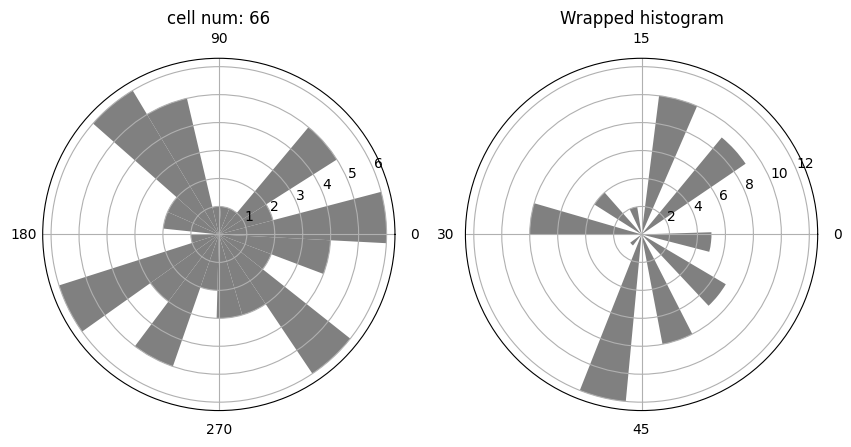

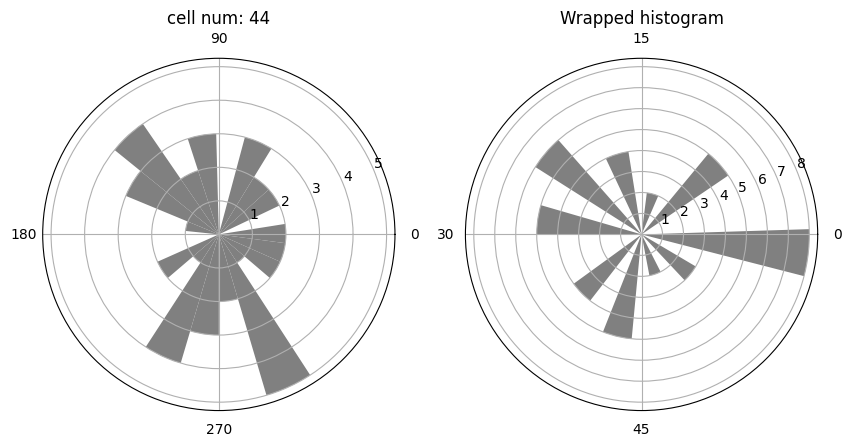

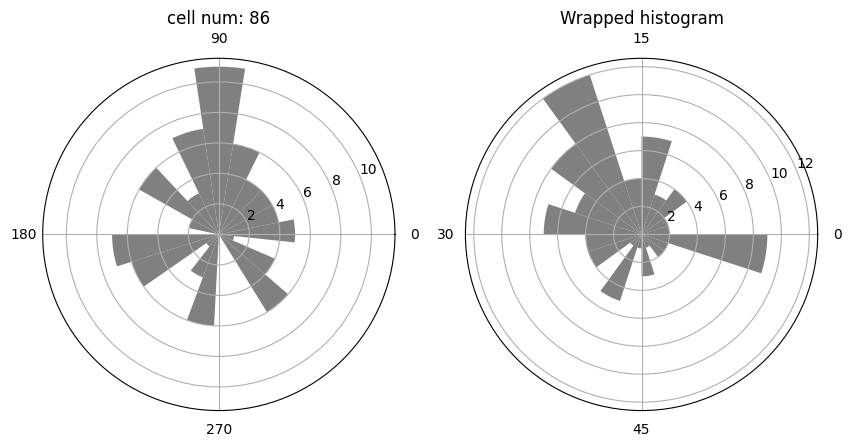

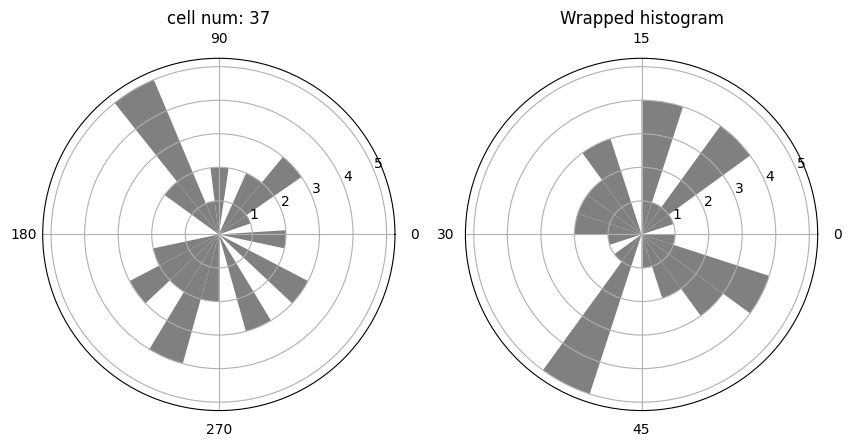

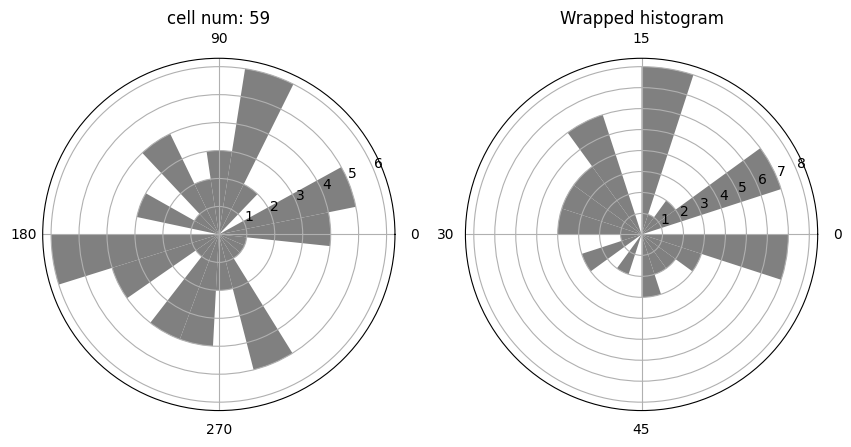

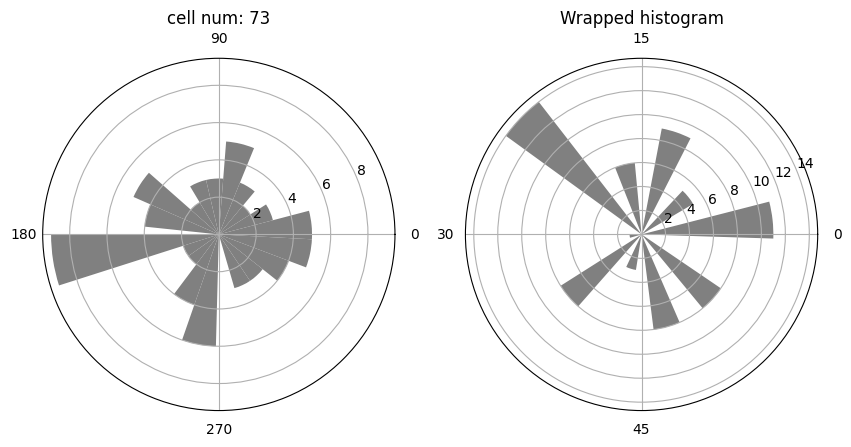

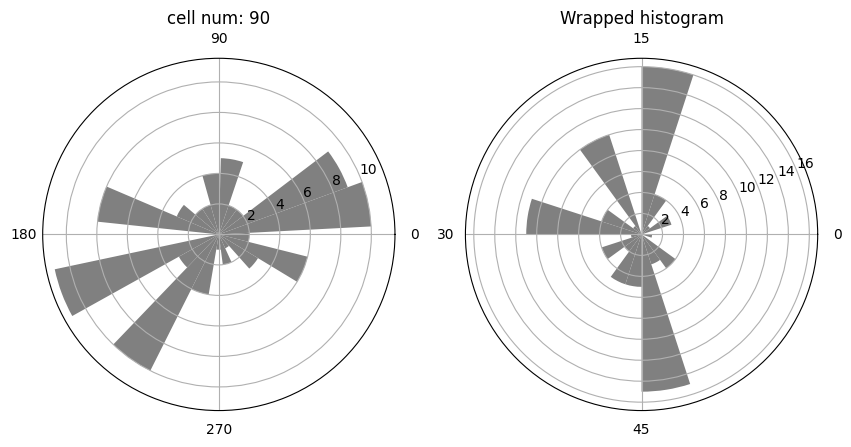

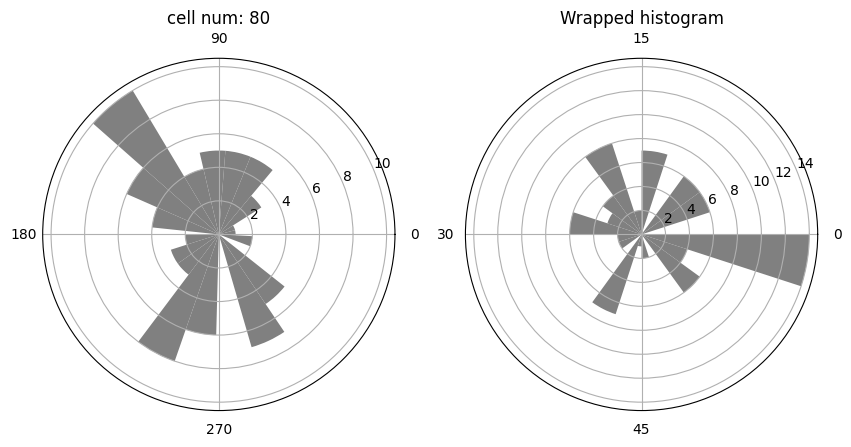

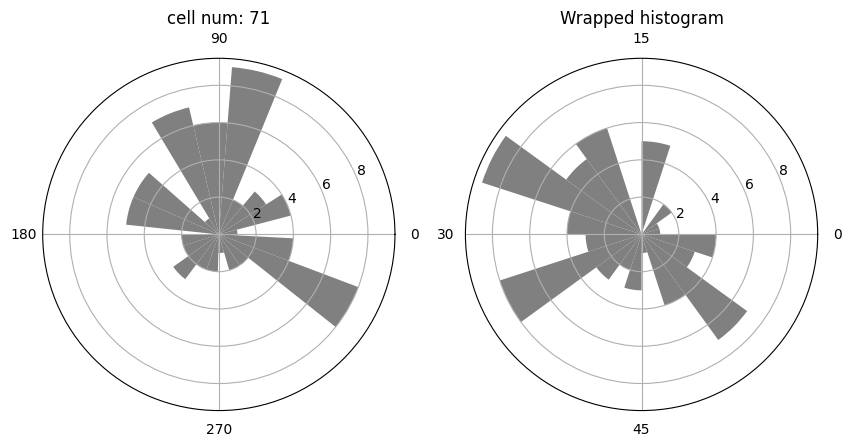

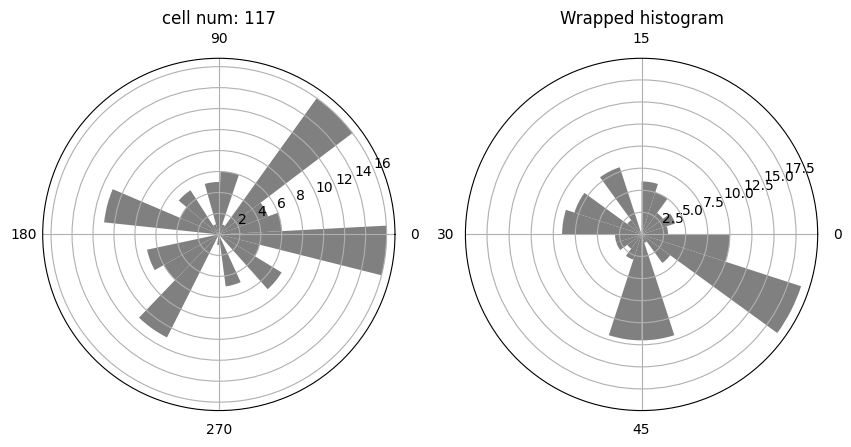

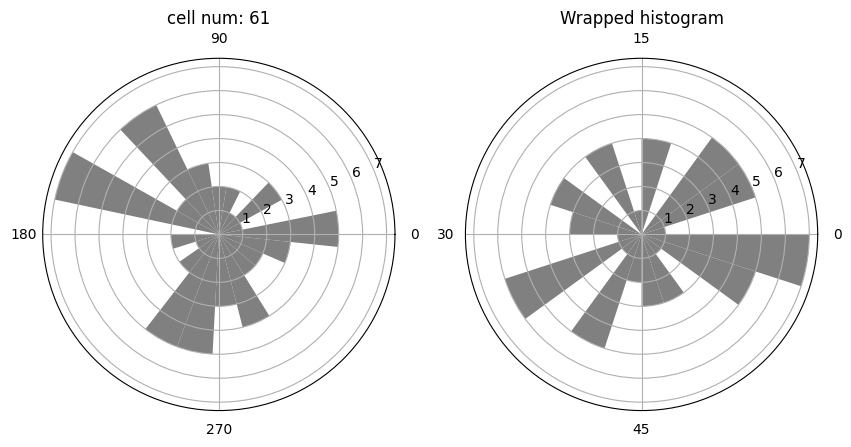

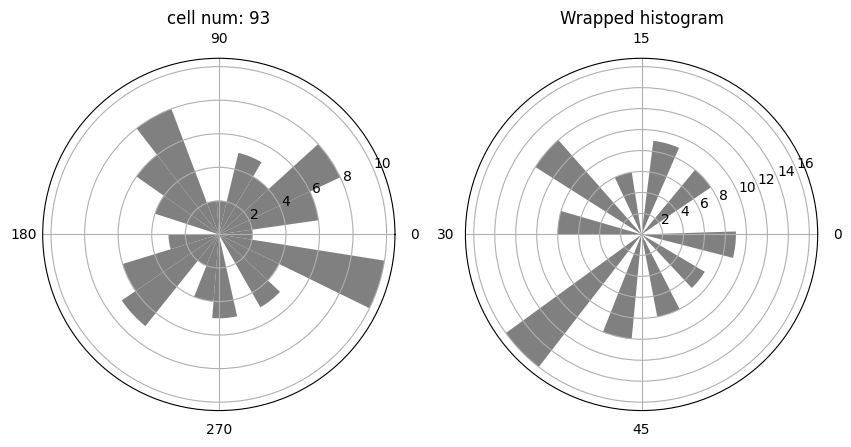

In [14]:
# all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
dataset = 'Dataset_1'
folders = os.listdir('/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset)

for folder in folders:
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Data'
    
    print('processing ' + mousetrial)
    
    #load data
    data = utils.load_data(mousetrial)
    t = data['t']
    angle_data = data['angle_data']
    brainarea = data['pos'] #adn = data['pos']
    hd = data['hd']
    spike_times = data['spike_times']
    
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
    }
    
    #plot all directional tuning
    fig = plt.figure(figsize=(2*len(spike_times),2))
    
    PreferredDir = []
    
    for i in range(len(spike_times)):
        spike_time_cell_i = spike_times[i]
        spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

        #calculate the head direction angle when spike_array_cell_i is not zero
        angle4spike = angle_data[spike_array_cell_i != 0]

        ax = fig.add_subplot(1, len(spike_times), i+1, polar=True)
        ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)
        
        if brainarea[i] == 1 and hd[i] == 1:
            PreferredDir.append(prefer_hd)
    
    plt.close(fig)
    
    # Convert PreferredDir into a numpy array
    PreferredDir = np.array(PreferredDir)
    # Create the figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'polar': True})

    # First plot: Original distribution
    ax = axs[0]
    ax.hist(PreferredDir, bins=20, color='gray')
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    ax.set_title('cell num: ' + str(len(PreferredDir)))

    # Second plot: Wrapped histogram into 60-degree periodicity
    ax = axs[1]
    #module PreferredDir from [-pi, pi] to [-pi/6,pi/6]
    wrapped_PreferredDir = ((PreferredDir + np.pi/6) % (np.pi/3)) - np.pi/6
    
    #time it back to 0 to 2pi by times 6
    wrapped_PreferredDir = wrapped_PreferredDir * 6
    
    #shift the data to be in range of [-pi, pi]
    wrapped_PreferredDir = (wrapped_PreferredDir + np.pi) % (2 * np.pi) - np.pi
    
    ax.hist(wrapped_PreferredDir, bins=20, color='gray')
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '15', '30', '45'])
    ax.set_title('Wrapped histogram')

